## Miniproject 2: MovieLens Visualization



# Imports, downloads

In [4]:
# Imports
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
!pip install adjustText
from adjustText import adjust_text

### Download data

In [5]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


# **Data Loading and Preprocessing**

In [6]:
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Using the data cleanup feature of Google Sheets, it was found that the 'Movie Title' columns of 'movies.csv' has duplicates with different 'Movie ID's.

In [ ]:
# Remove duplicates
duplicates = movies[movies.duplicated('Movie Title', keep=False)] # 36 duplicates
# Group the duplicates by their titles so group of duplicates have same 'Movie ID'
duplicate_IDs = duplicates.groupby('Movie Title')['Movie ID'].apply(np.array).reset_index(name='Duplicate ID')['Duplicate ID']
# Consolidate duplicate 'Movie Title's under a single 'Movie ID' to ensure consistency in dataset
for IDs in duplicate_IDs:
  for i in range(1, len(IDs)):
    data['Movie ID'].replace({IDs[i]: IDs[0]}, inplace=True)
    train['Movie ID'].replace({IDs[i]: IDs[0]}, inplace=True)
    test['Movie ID'].replace({IDs[i]: IDs[0]}, inplace=True)

# **Basic Visualizations**

1. All ratings in the MovieLens Dataset.

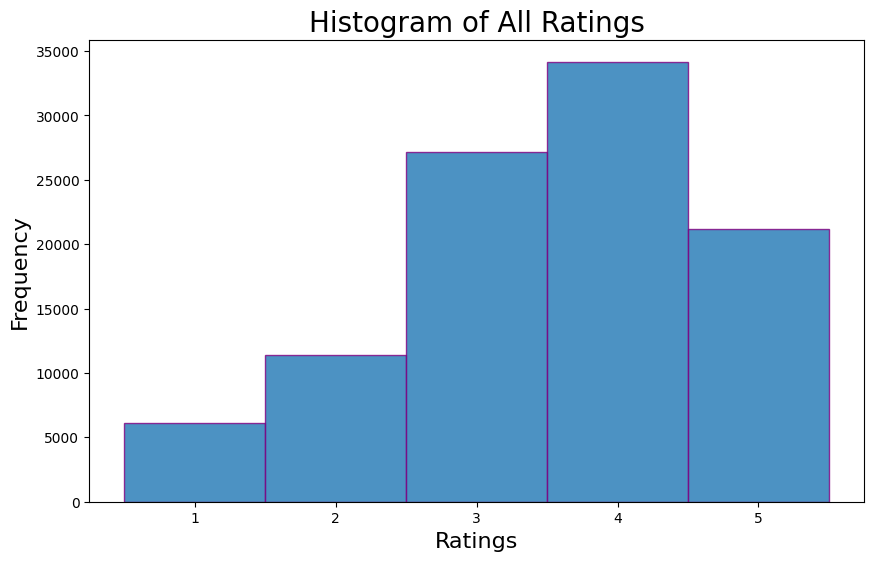

In [ ]:
ratings = data['Rating']

plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='purple', alpha=0.8)
plt.title('Histogram of All Ratings', fontsize=20)
plt.xlabel('Ratings', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks([1, 2, 3, 4, 5])

plt.show()

2. All ratings of the ten most popular movies (movies which have received the most ratings).

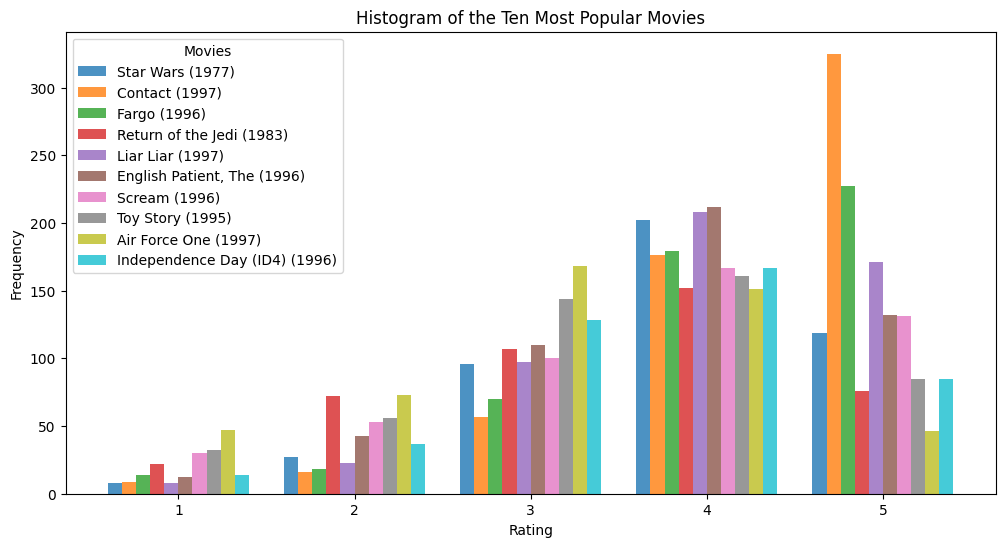

In [ ]:
# Group ratings by 'Movie ID' and count the number of ratings for each movie
num_ratings = data.groupby('Movie ID')['Rating'].count()
# Gets IDs of the top 10 most rated movies
top_rated_movies_IDs = num_ratings.nlargest(10).index
# Gets 'Movie Title's for the top 10 most rated movies
top_rated_movies_titles = movies.set_index('Movie ID').loc[top_rated_movies_IDs]['Movie Title']
# Gets ratings for the top 10 most rated movies
top_rated_movies_ratings = data[data['Movie ID'].isin(top_rated_movies_IDs)].groupby('Movie ID')['Rating']

hist_data = [group for name, group in top_rated_movies_ratings]
labels = top_rated_movies_titles.tolist()

plt.figure(figsize=(12, 6))
plt.hist(hist_data, bins=np.arange(0.5, 6.5, 1), label=labels, alpha=0.8)

plt.legend(title='Movies', fontsize=10)
plt.title('Histogram of the Ten Most Popular Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

3. All ratings of the ten best movies (movies with the highest average ratings).

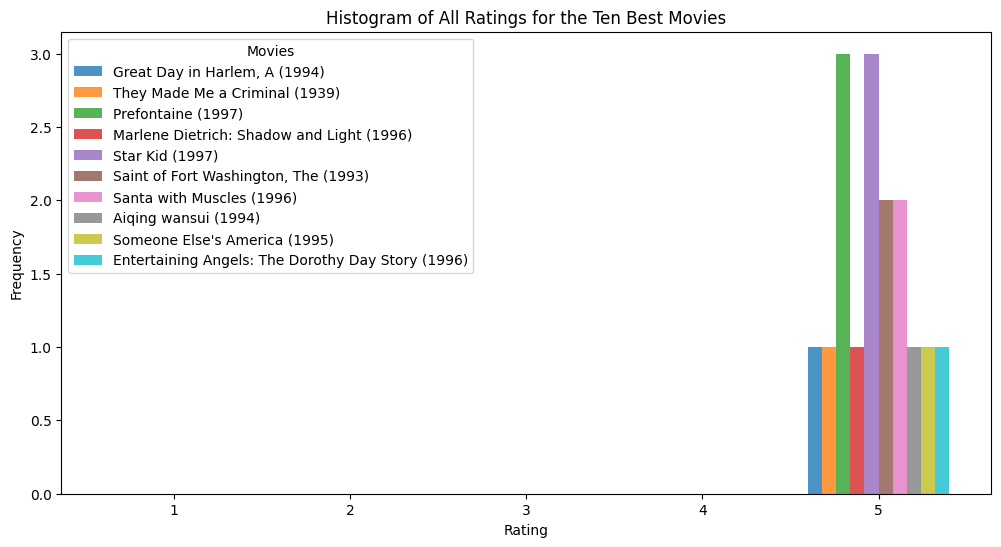

In [ ]:
average_ratings = data.groupby('Movie ID')['Rating'].mean()
# Gets IDs of the top 10 best rated movies
top_movies_IDs = average_ratings.nlargest(10).index
# Gets 'Movie Title's for the top 10 best rated movies
top_movies_titles = movies.set_index('Movie ID').loc[top_movies_IDs]['Movie Title']
# Gets ratings for the top 10 best rated movies
top_movies_ratings = data[data['Movie ID'].isin(top_movies_IDs)].groupby('Movie ID')['Rating']

hist_data = [group for name, group in top_movies_ratings]
labels = top_movies_titles.tolist()

plt.figure(figsize=(12, 6))
plt.hist(hist_data, bins=np.arange(0.5, 6.5, 1), label=labels, alpha=0.8)

plt.title('Histogram of All Ratings for the Ten Best Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend(title='Movies', fontsize=10)
plt.show()

We notice that the dataset is skewed upward, possibly due to case with movies having a small number of very high ratings. Since this is hindering data visualization, we try using weighted ratings, which takes into account both the average rating and the number of ratings. We use IMDb's formula.

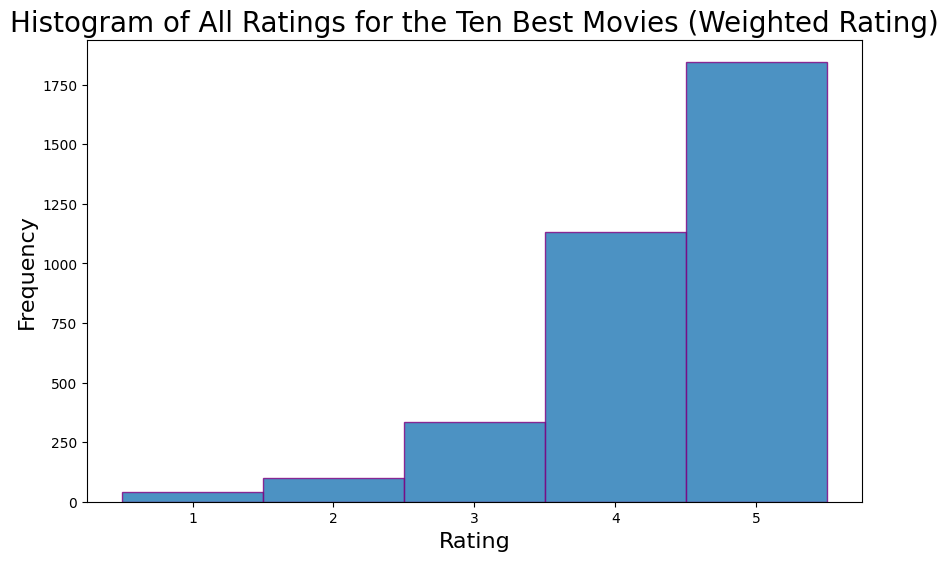

In [ ]:
# Gets the average rating and the count of ratings for each movie
movie_stats = data.groupby('Movie ID')['Rating'].agg(['mean', 'count'])

m = movie_stats['count'].quantile(0.90) # Movies must have more ratings than at least 90% of the movies to be considered
C = data['Rating'].mean() # Mean of all ratings

# Function to compute weighted rating given a movie
def weighted_rating(stats, m=m, C=C):
    v = stats['count']
    R = stats['mean']
    # Weight rating (using IMDb's formula)
    return (v/(v+m) * R) + (m/(m+v) * C)

# Add a new feature 'Weighted Rating' to movie_stats
movie_stats['Weighted Rating'] = movie_stats.apply(weighted_rating, axis=1)
# Sort movies based on 'Weighted Rating' and get indices of top 10
top_movie_IDs = movie_stats.sort_values('Weighted Rating', ascending=False).head(10).index
# Gets ratings for the top 10 movies
top_movies_ratings = data[data['Movie ID'].isin(top_movie_IDs)]['Rating']

plt.figure(figsize=(10, 6))
plt.hist(top_movies_ratings, bins=np.arange(0.5, 6.5, 1), edgecolor='purple', alpha=0.8)
plt.title('Histogram of All Ratings for the Ten Best Movies (Weighted Rating)', fontsize=20)
plt.xlabel('Rating', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(np.arange(1, 6))
plt.show()



4. All ratings of movies from three genres of your choice (create three separate visualizations).

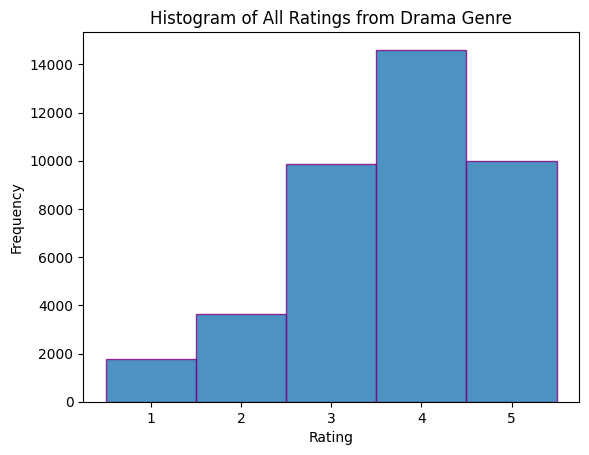

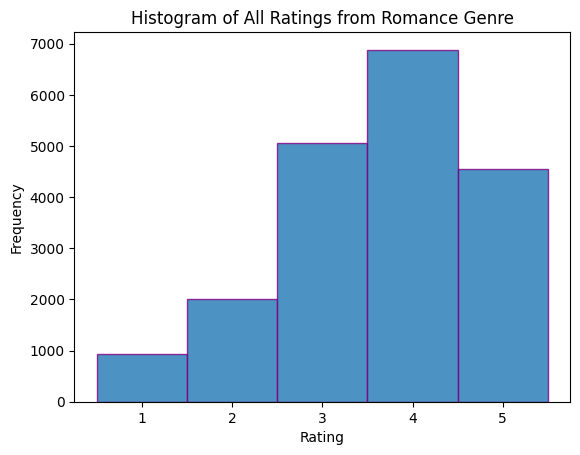

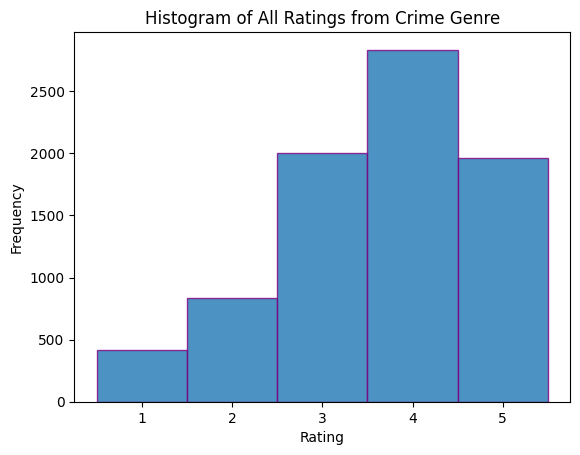

In [ ]:
for genre in ['Drama', 'Romance', 'Crime']:
  da_IDs = movies['Movie ID'][movies[genre] == 1]
  da_ratings = data['Rating'].loc[data['Movie ID'].isin(da_IDs)]

  plt.hist(da_ratings, bins = np.arange(0.5, 6.5, 1), edgecolor='purple', alpha=0.8)
  plt.title('Histogram of All Ratings from {} Genre'.format(genre))
  plt.xlabel('Rating')
  plt.ylabel('Frequency')
  plt.show()

# Matrix Factorization Visualizations

# Part 1

Factorizing with  943  users,  1682  movies.
943 1682 20
Epoch 1
----------------------------
Training loss: 0.62167
Test loss: 0.68984

Epoch 2
----------------------------
Training loss: 0.56176
Test loss: 0.64709

Epoch 3
----------------------------
Training loss: 0.52389
Test loss: 0.62353

Epoch 4
----------------------------
Training loss: 0.49342
Test loss: 0.60543

Epoch 5
----------------------------
Training loss: 0.46856
Test loss: 0.59046

Epoch 6
----------------------------
Training loss: 0.44809
Test loss: 0.57770

Epoch 7
----------------------------
Training loss: 0.43088
Test loss: 0.56661

Epoch 8
----------------------------
Training loss: 0.41609
Test loss: 0.55680

Epoch 9
----------------------------
Training loss: 0.40314
Test loss: 0.54795

Epoch 10
----------------------------
Training loss: 0.39162
Test loss: 0.53987

Epoch 11
----------------------------
Training loss: 0.38127
Test loss: 0.53242

Epoch 12
----------------------------
Training loss: 0.37189


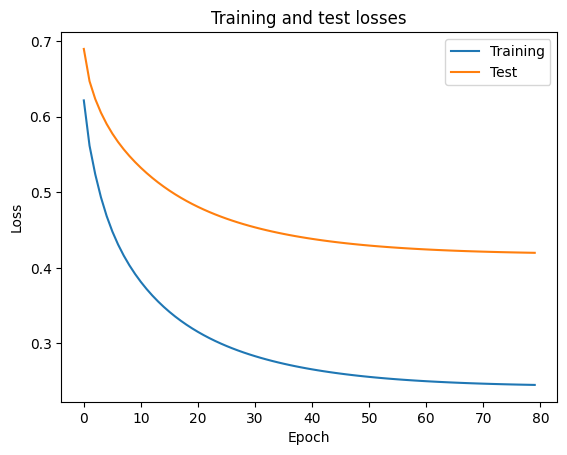

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """


    return (reg * Ui - Vj * (Yij - np.dot(Ui, Vj))) * eta

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """


    return (reg * Vj - Ui * (Yij - np.dot(Ui, Vj))) * eta

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """

    loss_sum = 0
    for data_point in Y:
        i, j, Y_ij = data_point
        i, j = i-1, j-1

        loss = reg/2 * (np.linalg.norm(U, ord='fro') + np.linalg.norm(V, ord='fro')) + 1/2 * (Y_ij - np.dot(U[i], V[j]))**2
        loss_sum += loss

    return loss_sum / len(Y)


def train_model(M, N, K, eta, reg, Y, test_set, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.uniform(low=-0.5, high=0.5, size=(M, K))
    V = np.random.uniform(low=-0.5, high=0.5, size=(N, K))

    E_in = []
    E_out = []

    max_epochs = 80
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}\n----------------------------")
        for data_point in Y:
            i, j, Y_ij = data_point
            i, j = i-1, j-1

            grad_u_now = grad_U(U[i], Y_ij, V[j], reg, eta)
            grad_v_now = grad_V(V[j], Y_ij, U[i], reg, eta)

            U[i] = U[i] - grad_u_now
            V[j] = V[j] - grad_v_now

        '''
        if epoch == 0:
            loss_0 = get_err(U, V, Y, reg=reg)
        elif epoch == 1:
            loss = get_err(U, V, Y, reg=reg)
            initial_reduction = loss_0 - loss
        else:
            loss_prev = loss
            loss = get_err(U, V, Y, reg=reg)

            print(f'Loss: {loss:.5f}')
            # print(f'{((loss_prev - loss) / initial_reduction):.5f}')
            # if ((loss_prev - loss) / initial_reduction) <= eps:
            #     break
        '''

        training_loss = get_err(U, V, Y)
        test_loss = get_err(U, V, test_set)

        E_in.append(training_loss)
        E_out.append(test_loss)

        print(f'Training loss: {training_loss:.5f}')
        print(f'Test loss: {test_loss:.5f}\n')

        eta = eta * 0.96


    plt.title('Training and test losses')
    plt.plot(E_in, label='Training')
    plt.plot(E_out, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('method1-train_loss.png')

    err = get_err(U, V, Y, reg=reg)

    return (U, V, err)


Y_train = np.array(train)
Y_test = np.array(test)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.1
eta = 0.1 # learning rate
E_in = []
E_out = []

print(M, N, K)
U,V, err = train_model(M, N, K, eta, reg, Y_train, test_set=Y_test)



### Figures

In [ ]:
# Algorithm gives Y = U V^T. For this project, we need Y = U^T V, so U = U.transpose() and V = V.transpose()
SVD = np.linalg.svd(V.T) # get SVD for V
A = SVD[0]
# Project U and V into a two dimensional space
U_tilde =  np.matmul(A[:, :2].T, U.T)
V_tilde =  np.matmul(A[:, :2].T, V.T)

# Used to print movie names on 2d projections
all_movie_names = np.array(movies)[:,1]

In [ ]:
# Figure for a list of 10 custom movie selections
movies_indices = [56, 156, 346, 649, 127, 187, 50, 181, 439, 437]
movies_indices = [i-1 for i in movies_indices]
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

"""
For seaborn:
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    #genre = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist() In case we want to add it
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)
"""

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method1_10_custom')
plt.close()

In [ ]:
# Figure for the most popular movies
# All ratings of the ten most popular movies (movies which have received the most ratings).
movies_indices = data["Movie ID"].value_counts().head(10).index - 1 # Make sure to 0-index the movies
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

plt.title('2D Projection of the Ten Most Popular Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method1_10_most_popular')
plt.close()

In [ ]:
# Figure of the ten best movies (movies with the highest average ratings).
average_ratings = data.groupby('Movie ID')['Rating'].mean()
movies_indices = average_ratings.nlargest(10).index -1 # Make sure to 0-index
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

plt.title('2D Projection of the Ten best Movies (by average ratings)', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method1_10_best_popular(avg)')
plt.close()

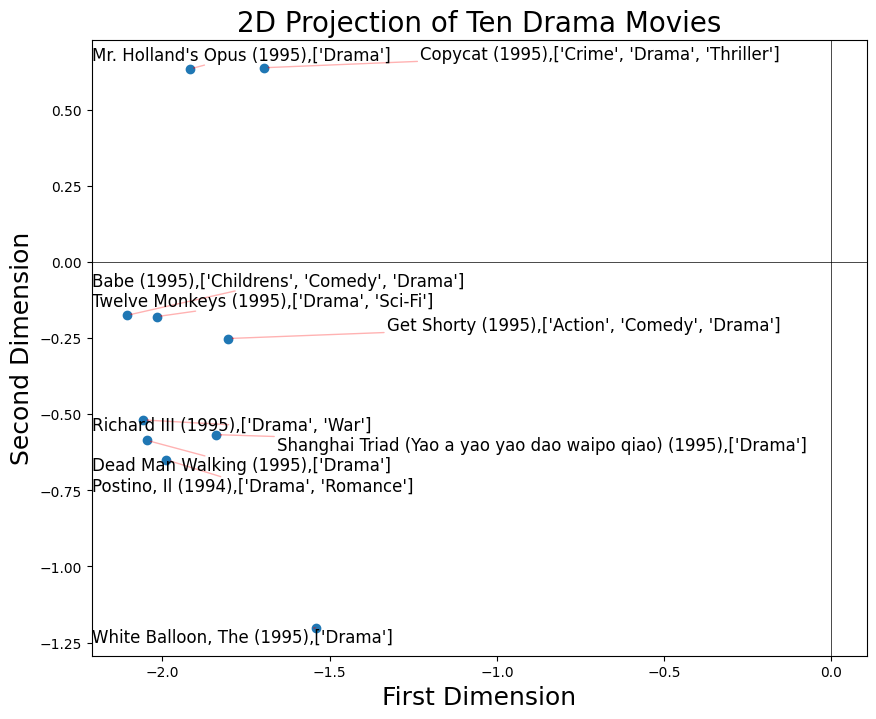

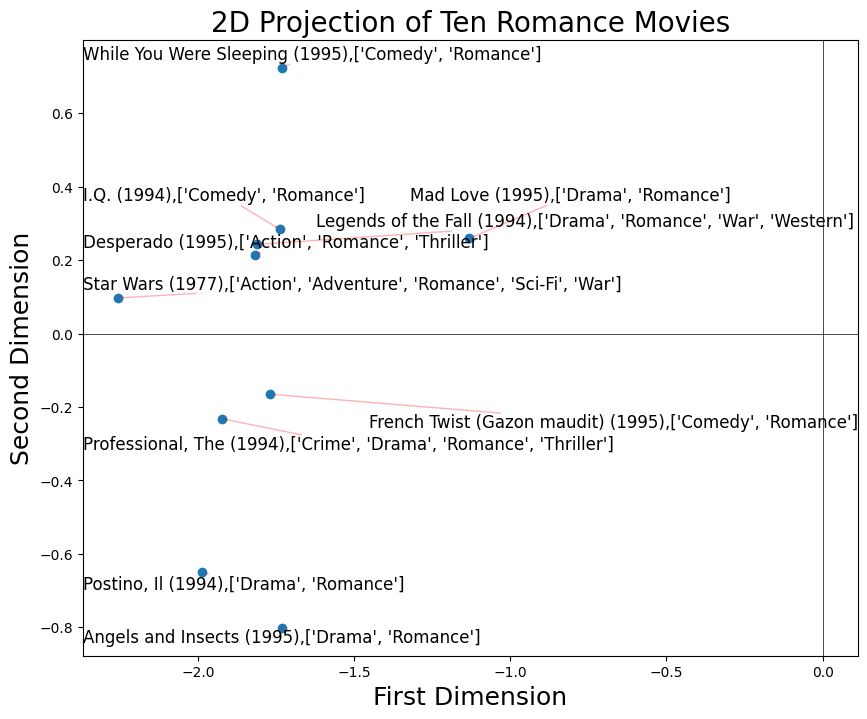

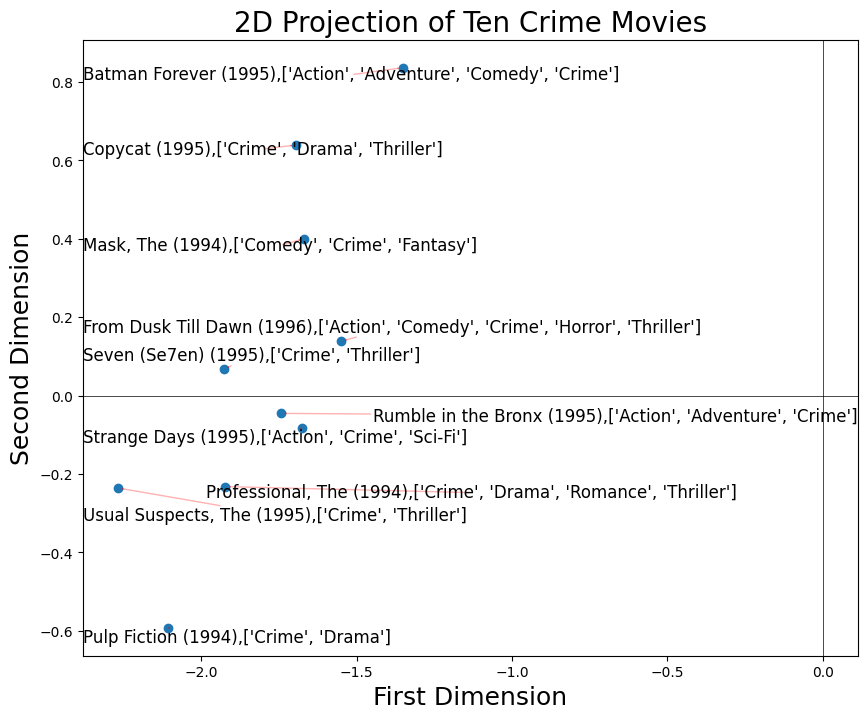

In [ ]:
# Ten movies from the three genres you selected in Section 4

for genre in ['Drama', 'Romance', 'Crime']:

  movies_indices = movies[movies[genre] == 1].head(10).index # no need to 0-index
  movies_2D = V_tilde[:, movies_indices]
  movies_names = all_movie_names[movies_indices]

  plt.figure(figsize=(10, 8))
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  scatter = plt.scatter(movies_2D[0], movies_2D[1])
  labels =[]
  for i, movie in enumerate(movies_names):
      genres = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist()
      labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], f'{movie},{genres}', fontsize=12))

  adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

  plt.title(f'2D Projection of Ten {genre} Movies', fontsize=20)
  plt.xlabel('First Dimension', fontsize=18)
  plt.ylabel('Second Dimension', fontsize=18)
  # plt.savefig(f'method1_10_{genre}')
  # plt.close()

# Part 2

## Bias Base Version





Factorizing with  943  users,  1682  movies.
943 1682 20
Epoch 1: err=0.48973173425025524
Epoch 3
----------------------------
Training loss: 0.43814
Test loss: 0.50030

Epoch 4
----------------------------
Training loss: 0.40988
Test loss: 0.48787

Epoch 5
----------------------------
Training loss: 0.38942
Test loss: 0.48222

Epoch 6
----------------------------
Training loss: 0.37219
Test loss: 0.47979

Epoch 7
----------------------------
Training loss: 0.35643
Test loss: 0.47917

Epoch 8
----------------------------
Training loss: 0.34152
Test loss: 0.47976

Epoch 9
----------------------------
Training loss: 0.32742
Test loss: 0.48126

Epoch 10
----------------------------
Training loss: 0.31422
Test loss: 0.48354

Epoch 11
----------------------------
Training loss: 0.30204
Test loss: 0.48645

Epoch 12
----------------------------
Training loss: 0.29088
Test loss: 0.48984

Epoch 13
----------------------------
Training loss: 0.28073
Test loss: 0.49356

Epoch 14
-----------------

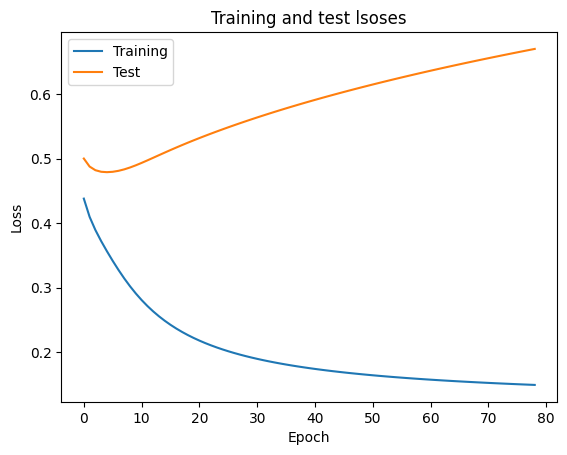

In [ ]:
# Set random seed
np.random.seed(1856)


# SVD model with bias a and b

def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), ai (the ith element of a), bj (the jth
    element of b), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), ai (the ith element of a), bj (the jth element of b),
    mu (the mean of the ratings), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_a(ai, Ui, Yij, Vj, bj, mu, reg, eta):
    """
    Takes as input the scalar ai (the ith element of a), Ui (the ith row of U),
    a training point Yij, the column vector Vj (jth column of V^T), bj (the jth
    element of b), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to ai multiplied by eta.
    """
    return eta * (reg * ai - (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_b(bj, Ui, Yij, Vj, ai, mu, reg, eta):
    """
    Takes as input the scalar bj (the jth element of b), Ui (the ith row of U),
    a training point Yij, the column vector Vj (jth column of V^T), ai (the ith
    element of a), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to bj multiplied by eta.
    """
    return eta * (reg * bj - (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def get_err(U, V, a, b, Y, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j, and
    user/movie matrices U and V, and vectors a and b.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for row in Y:
        i, j, Yij = row
        err += (Yij - mu - np.dot(U[i-1], V[j-1]) - a[i-1] - b[j-1])**2
    err /= 2
    return err / len(Y)

def train_model(M, N, K, eta, reg, Y, test_set, eps=0.0001, max_epochs=80):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, a, b, err) consisting of U, V, a, and b, and the
    unregularized MSE of the model.
    """
    U = np.random.random((M, K)) - 0.5
    V = np.random.random((N, K)) - 0.5
    a = np.random.random(M) - 0.5
    b = np.random.random(N) - 0.5
    mu = np.mean([rating for _, _, rating in Y])

    # First epoch
    for i in range(len(Y)):
        j, k, Yij = Y[i]
        U[j-1] -= grad_U(U[j-1], Yij, V[k-1], a[j-1], b[k-1], mu, reg, eta)
        V[k-1] -= grad_V(V[k-1], Yij, U[j-1], a[j-1], b[k-1], mu, reg, eta)
        a[j-1] -= grad_a(a[j-1], U[j-1], Yij, V[k-1], b[k-1], mu, reg, eta)
        b[k-1] -= grad_b(b[k-1], U[j-1], Yij, V[k-1], a[j-1], mu, reg, eta)
    losses = [get_err(U, V, a, b, Y, mu, reg)]
    print('Epoch 1: err={}'.format(losses[0]))

    E_in = []
    E_out = []

    Y_copy = Y.copy()
    # Subsequent epochs
    for epoch in range(2, max_epochs + 1):
        Y_copy = np.random.permutation(Y_copy)

        for i in range(len(Y_copy)):
            j, k, Yij = Y[i]
            U[j-1] -= grad_U(U[j-1], Yij, V[k-1], a[j-1], b[k-1], mu, reg, eta)
            V[k-1] -= grad_V(V[k-1], Yij, U[j-1], a[j-1], b[k-1], mu, reg, eta)
            a[j-1] -= grad_a(a[j-1], U[j-1], Yij, V[k-1], b[k-1], mu, reg, eta)
            b[k-1] -= grad_b(b[k-1], U[j-1], Yij, V[k-1], a[j-1], mu, reg, eta)
        err = get_err(U, V, a, b, Y, mu, reg)
        losses.append(err)

        '''
        print('Epoch {}: err={}'.format(epoch, err))
        if losses[-2] - losses[-1] < eps * (losses[0] - losses[1]):
            break
        '''

        training_loss = get_err(U, V, a, b, Y, mu)
        test_loss = get_err(U, V, a, b, test_set, mu)

        E_in.append(training_loss)
        E_out.append(test_loss)

        print(f"Epoch {epoch+1}\n----------------------------")
        print(f'Training loss: {training_loss:.5f}')
        print(f'Test loss: {test_loss:.5f}\n')


    plt.title('Training and test lsoses')
    plt.plot(E_in, label='Training')
    plt.plot(E_out, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('2d.png')

    return U, V, a, b, losses[-1]


Y_train = np.array(train)
Y_test = np.array(test)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.01 # learning rate

print(M, N, K)
U,V, a, b, err = train_model(M, N, K, eta, reg, Y_train, test_set=Y_test)

### Figures

In [ ]:
# Algorithm gives Y = U V^T. For this project, we need Y = U^T V, so U = U.transpose() and V = V.transpose()
SVD = np.linalg.svd(V.T) # get SVD for V
A = SVD[0]
# Project U and V into a two dimensional space
U_tilde =  np.matmul(A[:, :2].T, U.T)
V_tilde =  np.matmul(A[:, :2].T, V.T)

# Used to print movie names on 2d projections
all_movie_names = np.array(movies)[:,1]

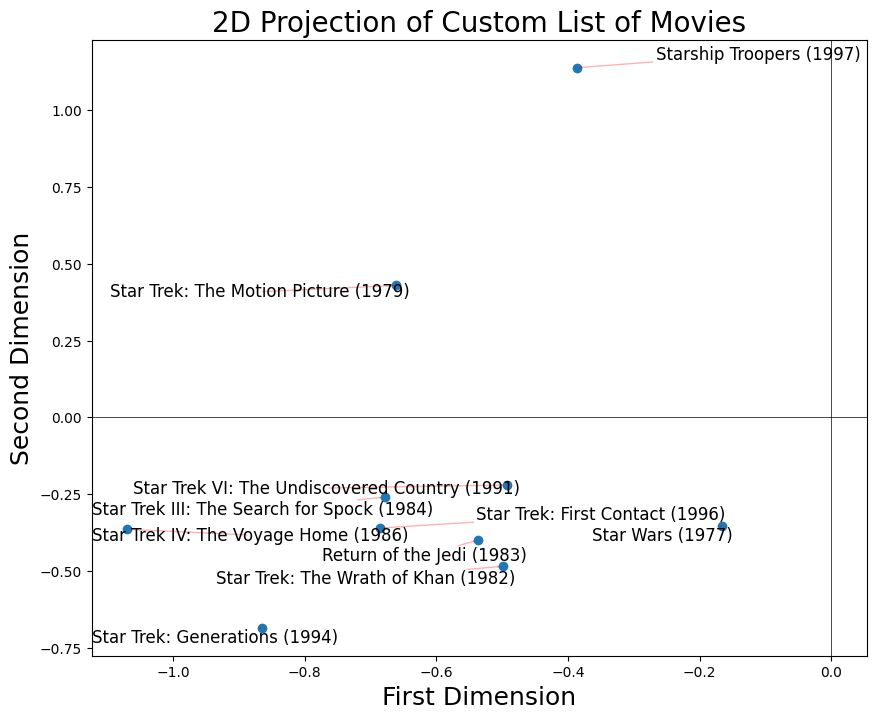

In [ ]:
# Figure for a list of 10 custom movie selections
movies_indices = [222, 227, 228, 229, 230, 271, 380, 449, 181, 50]
# movies_indices = [56, 156, 346, 649, 127, 187, 50, 181, 439, 437]
movies_indices = [i-1 for i in movies_indices]
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

"""
For seaborn:
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    #genre = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist() In case we want to add it
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)
"""

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method2-1_10_custom')
plt.show()
plt.close()

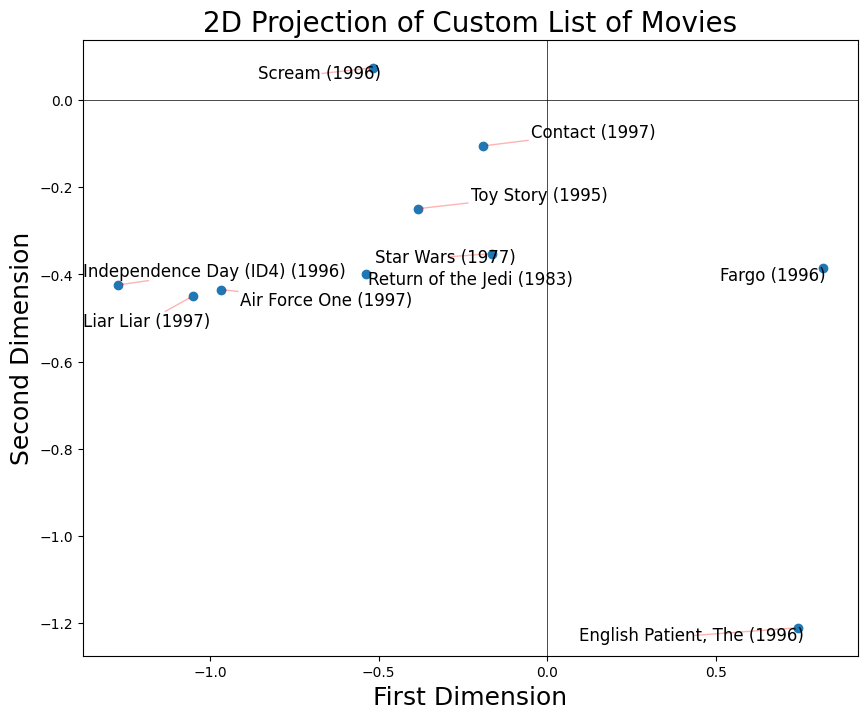

In [ ]:
# Figure for the most popular movies
# All ratings of the ten most popular movies (movies which have received the most ratings).
movies_indices = data["Movie ID"].value_counts().head(10).index - 1 # Make sure to 0-index the movies
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

"""
For seaborn:
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    #genre = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist() In case we want to add it
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)
"""

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method2-1_10_most_popular')
plt.show()
plt.close()

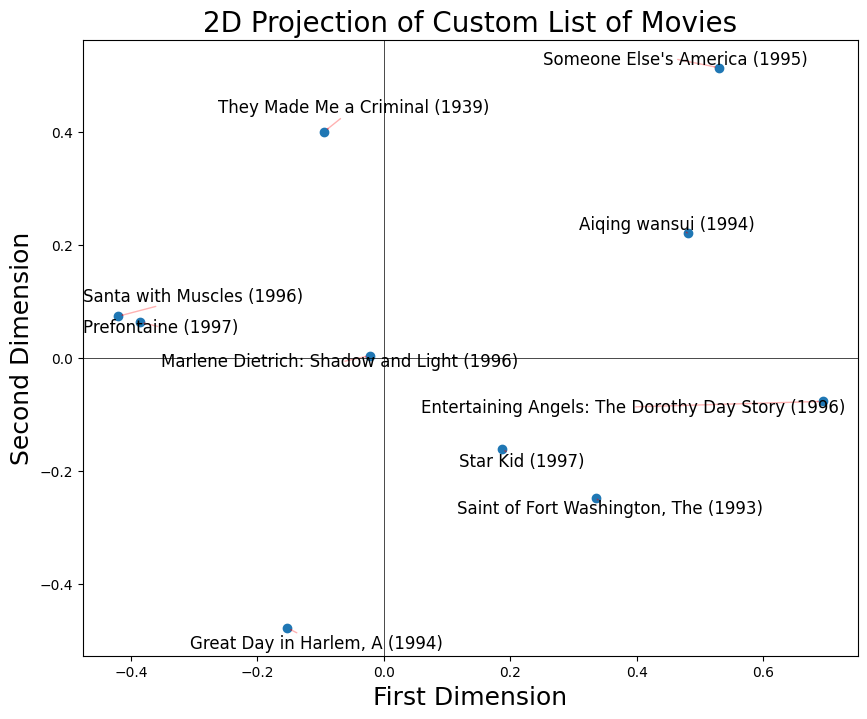

In [ ]:
# Figure of the ten best movies (movies with the highest average ratings).
average_ratings = data.groupby('Movie ID')['Rating'].mean()
movies_indices = average_ratings.nlargest(10).index -1 # Make sure to 0-index
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

"""
For seaborn:
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    #genre = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist() In case we want to add it
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)
"""

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method2-1_10_best_popular(avg)')
plt.show()
plt.close()

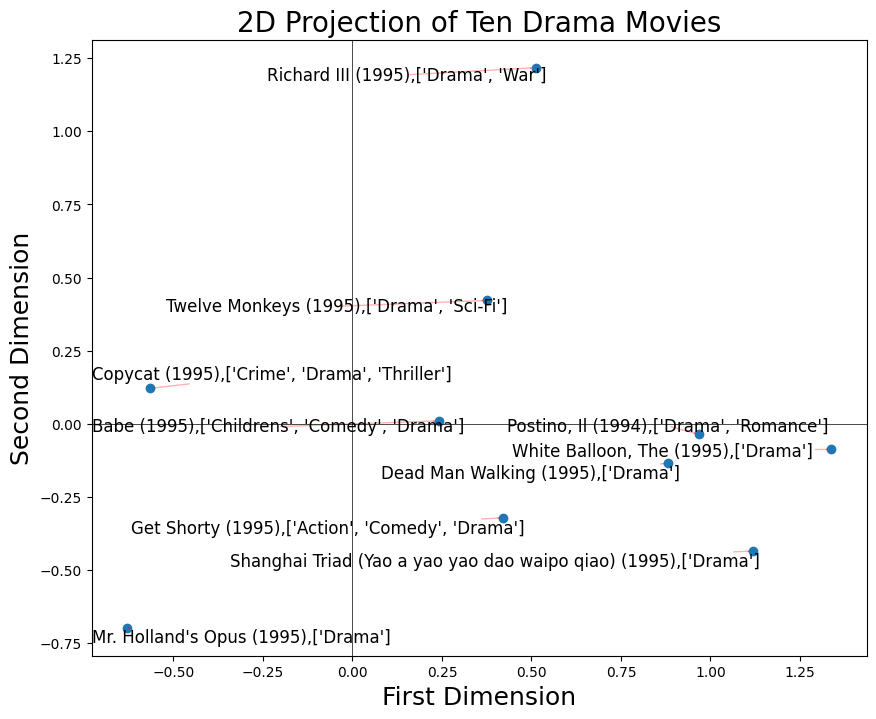

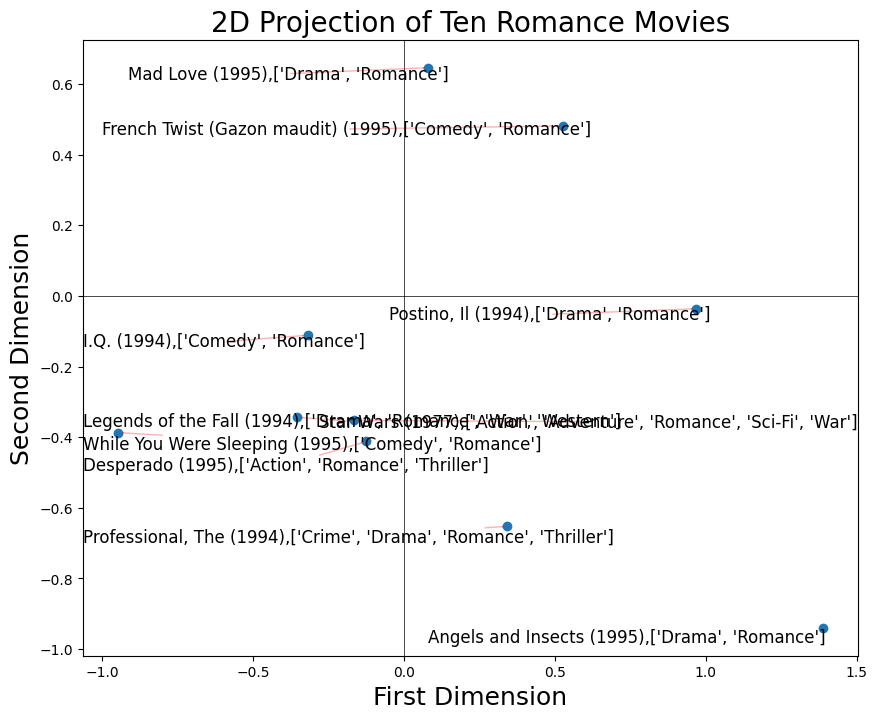

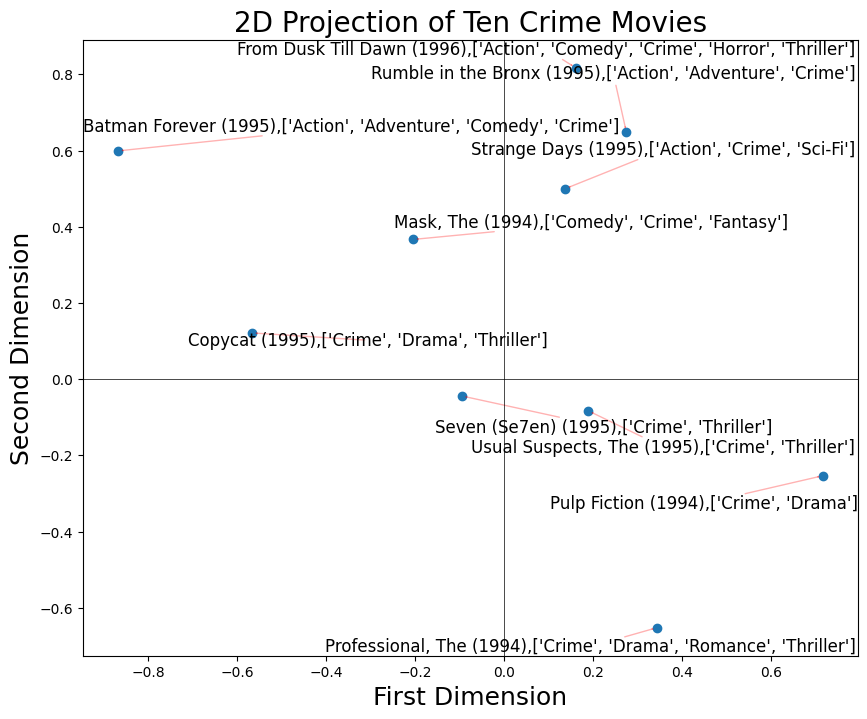

In [ ]:
# Ten movies from the three genres you selected in Section 4

for genre in ['Drama', 'Romance', 'Crime']:

  movies_indices = movies[movies[genre] == 1].head(10).index # no need to 0-index
  movies_2D = V_tilde[:, movies_indices]
  movies_names = all_movie_names[movies_indices]

  plt.figure(figsize=(10, 8))
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  scatter = plt.scatter(movies_2D[0], movies_2D[1])
  labels =[]
  for i, movie in enumerate(movies_names):
      genres = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist()
      labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], f'{movie},{genres}', fontsize=12))

  adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

  plt.title(f'2D Projection of Ten {genre} Movies', fontsize=20)
  plt.xlabel('First Dimension', fontsize=18)
  plt.ylabel('Second Dimension', fontsize=18)

## With regularization

Factorizing with  943  users,  1682  movies.
943 1682 20
Epoch 1: err=0.4803062009816439
Epoch 3
----------------------------
Training loss: 0.43657
Test loss: 0.47820

Epoch 4
----------------------------
Training loss: 0.41809
Test loss: 0.46425

Epoch 5
----------------------------
Training loss: 0.40779
Test loss: 0.45697

Epoch 6
----------------------------
Training loss: 0.40096
Test loss: 0.45249

Epoch 7
----------------------------
Training loss: 0.39578
Test loss: 0.44938

Epoch 8
----------------------------
Training loss: 0.39138
Test loss: 0.44695

Epoch 9
----------------------------
Training loss: 0.38730
Test loss: 0.44487

Epoch 10
----------------------------
Training loss: 0.38330
Test loss: 0.44292

Epoch 11
----------------------------
Training loss: 0.37924
Test loss: 0.44101

Epoch 12
----------------------------
Training loss: 0.37507
Test loss: 0.43910

Epoch 13
----------------------------
Training loss: 0.37082
Test loss: 0.43719

Epoch 14
------------------

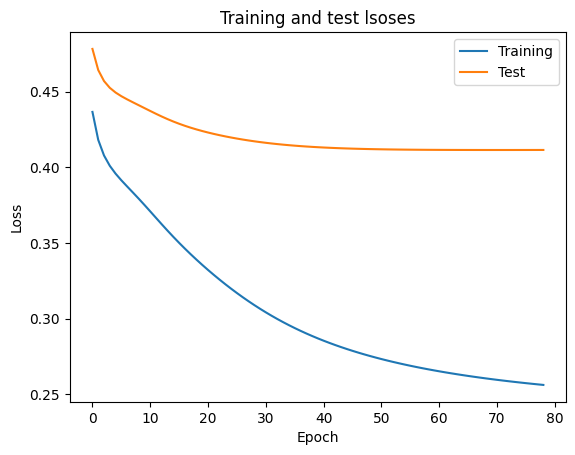

In [ ]:
# Set random seed
np.random.seed(1856)


# SVD model with bias a and b

def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), ai (the ith element of a), bj (the jth
    element of b), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), ai (the ith element of a), bj (the jth element of b),
    mu (the mean of the ratings), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_a(ai, Ui, Yij, Vj, bj, mu, reg, eta):
    """
    Takes as input the scalar ai (the ith element of a), Ui (the ith row of U),
    a training point Yij, the column vector Vj (jth column of V^T), bj (the jth
    element of b), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to ai multiplied by eta.
    """
    return eta * (reg * ai - (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_b(bj, Ui, Yij, Vj, ai, mu, reg, eta):
    """
    Takes as input the scalar bj (the jth element of b), Ui (the ith row of U),
    a training point Yij, the column vector Vj (jth column of V^T), ai (the ith
    element of a), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to bj multiplied by eta.
    """
    return eta * (reg * bj - (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def get_err(U, V, a, b, Y, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j, and
    user/movie matrices U and V, and vectors a and b.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for row in Y:
        i, j, Yij = row
        err += (Yij - mu - np.dot(U[i-1], V[j-1]) - a[i-1] - b[j-1])**2
    err /= 2
    return err / len(Y)

def train_model(M, N, K, eta, reg, Y, test_set, eps=0.0001, max_epochs=80):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, a, b, err) consisting of U, V, a, and b, and the
    unregularized MSE of the model.
    """
    U = np.random.random((M, K)) - 0.5
    V = np.random.random((N, K)) - 0.5
    a = np.random.random(M) - 0.5
    b = np.random.random(N) - 0.5
    mu = np.mean([rating for _, _, rating in Y])

    # First epoch
    for i in range(len(Y)):
        j, k, Yij = Y[i]
        U[j-1] -= grad_U(U[j-1], Yij, V[k-1], a[j-1], b[k-1], mu, reg, eta)
        V[k-1] -= grad_V(V[k-1], Yij, U[j-1], a[j-1], b[k-1], mu, reg, eta)
        a[j-1] -= grad_a(a[j-1], U[j-1], Yij, V[k-1], b[k-1], mu, reg, eta)
        b[k-1] -= grad_b(b[k-1], U[j-1], Yij, V[k-1], a[j-1], mu, reg, eta)
    losses = [get_err(U, V, a, b, Y, mu, reg)]
    print('Epoch 1: err={}'.format(losses[0]))

    E_in = []
    E_out = []

    Y_copy = Y.copy()
    # Subsequent epochs
    for epoch in range(2, max_epochs + 1):
        Y_copy = np.random.permutation(Y_copy)

        for i in range(len(Y_copy)):
            j, k, Yij = Y[i]
            U[j-1] -= grad_U(U[j-1], Yij, V[k-1], a[j-1], b[k-1], mu, reg, eta)
            V[k-1] -= grad_V(V[k-1], Yij, U[j-1], a[j-1], b[k-1], mu, reg, eta)
            a[j-1] -= grad_a(a[j-1], U[j-1], Yij, V[k-1], b[k-1], mu, reg, eta)
            b[k-1] -= grad_b(b[k-1], U[j-1], Yij, V[k-1], a[j-1], mu, reg, eta)
        err = get_err(U, V, a, b, Y, mu, reg)
        losses.append(err)

        '''
        print('Epoch {}: err={}'.format(epoch, err))
        if losses[-2] - losses[-1] < eps * (losses[0] - losses[1]):
            break
        '''

        training_loss = get_err(U, V, a, b, Y, mu)
        test_loss = get_err(U, V, a, b, test_set, mu)

        E_in.append(training_loss)
        E_out.append(test_loss)

        print(f"Epoch {epoch+1}\n----------------------------")
        print(f'Training loss: {training_loss:.5f}')
        print(f'Test loss: {test_loss:.5f}\n')


    plt.title('Training and test lsoses')
    plt.plot(E_in, label='Training')
    plt.plot(E_out, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('2d.png')

    return U, V, a, b, losses[-1]


Y_train = np.array(train)
Y_test = np.array(test)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.1
eta = 0.01 # learning rate

print(M, N, K)
U,V, a, b, err = train_model(M, N, K, eta, reg, Y_train, test_set=Y_test)

### Figures

In [ ]:
# Algorithm gives Y = U V^T. For this project, we need Y = U^T V, so U = U.transpose() and V = V.transpose()
SVD = np.linalg.svd(V.T) # get SVD for V
A = SVD[0]
# Project U and V into a two dimensional space
U_tilde =  np.matmul(A[:, :2].T, U.T)
V_tilde =  np.matmul(A[:, :2].T, V.T)

# Used to print movie names on 2d projections
all_movie_names = np.array(movies)[:,1]

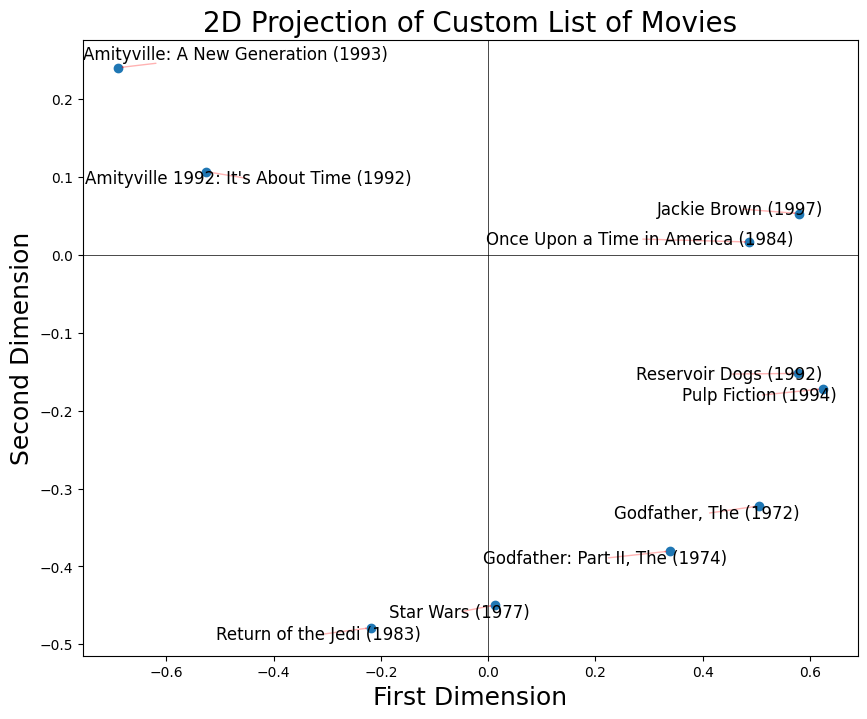

In [ ]:
# Figure for a list of 10 custom movie selections
movies_indices = [56, 156, 346, 649, 127, 187, 50, 181, 439, 437]
movies_indices = [i-1 for i in movies_indices]
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method2-2_10_custom')
plt.show()
plt.close()

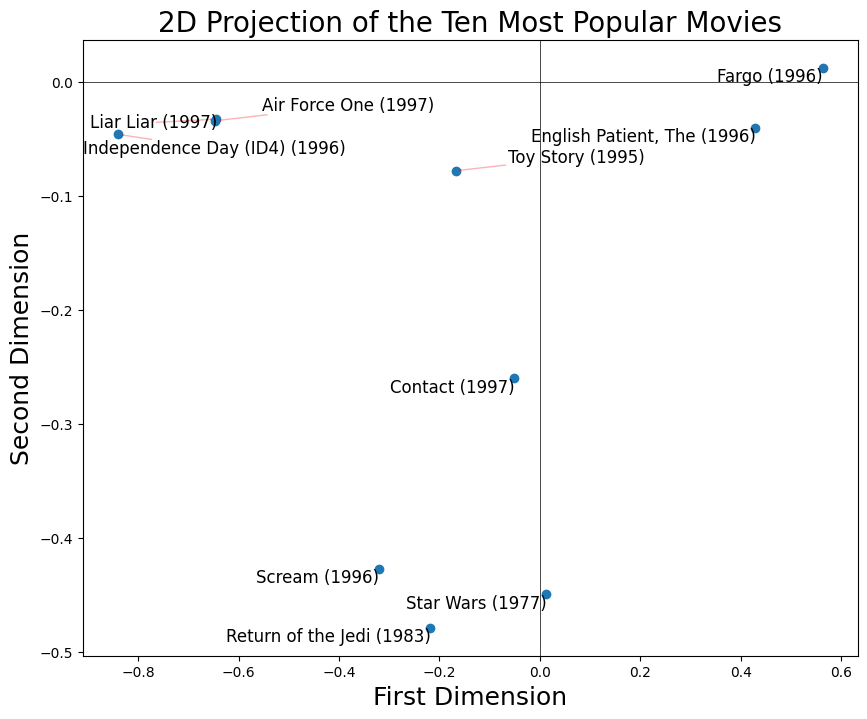

In [ ]:
# Figure for the most popular movies
# All ratings of the ten most popular movies (movies which have received the most ratings).
movies_indices = data["Movie ID"].value_counts().head(10).index - 1 # Make sure to 0-index the movies
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of the Ten Most Popular Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method2-2_10_most_popular')
plt.show()
plt.close()

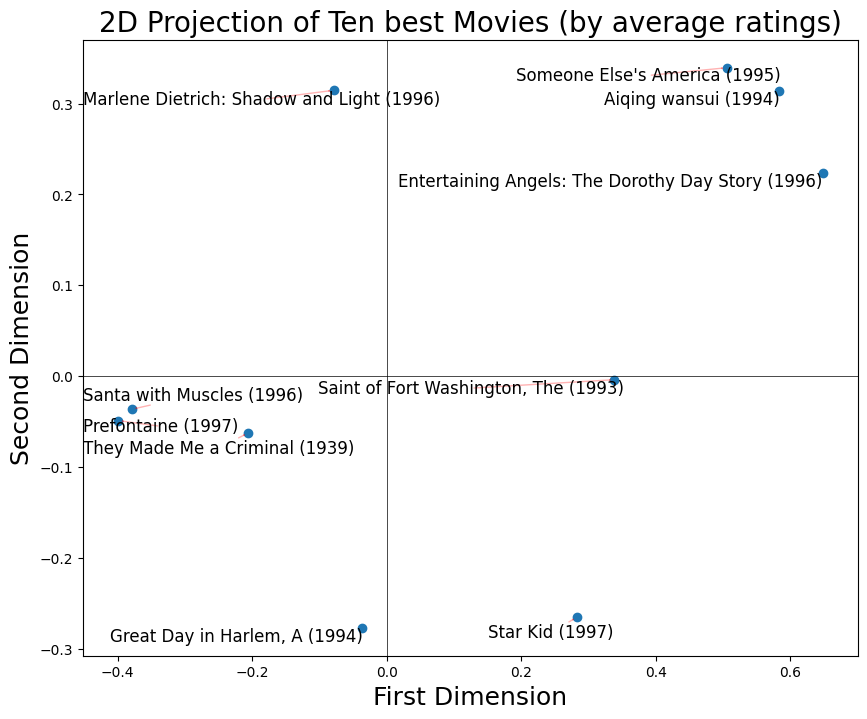

In [ ]:
# Figure of the ten best movies (movies with the highest average ratings).
average_ratings = data.groupby('Movie ID')['Rating'].mean()
movies_indices = average_ratings.nlargest(10).index -1 # Make sure to 0-index
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels =[]
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of Ten best Movies (by average ratings)', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.savefig('method2-2_10_best_popular(avg)')
plt.show()
plt.close()

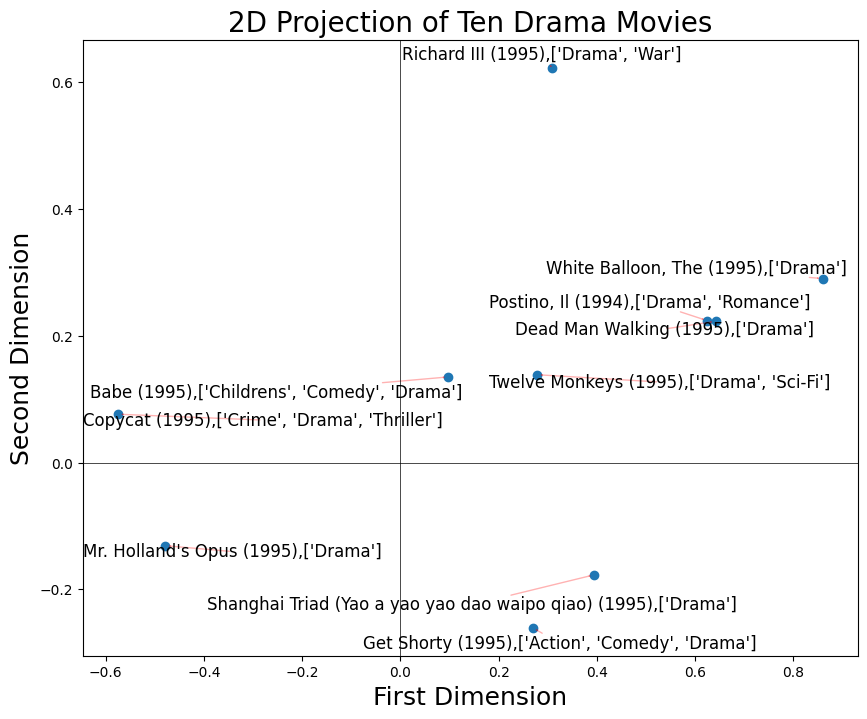

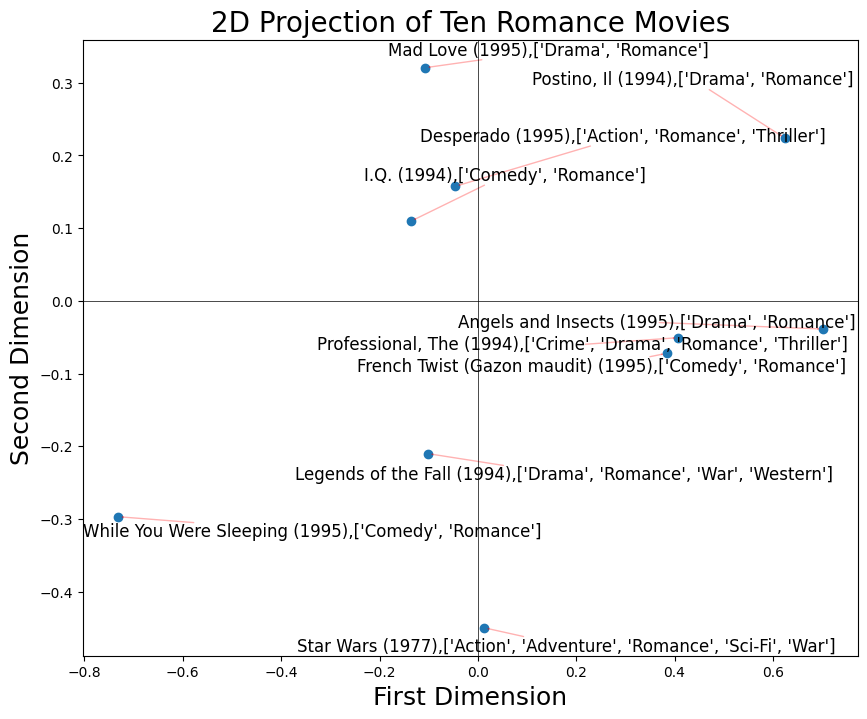

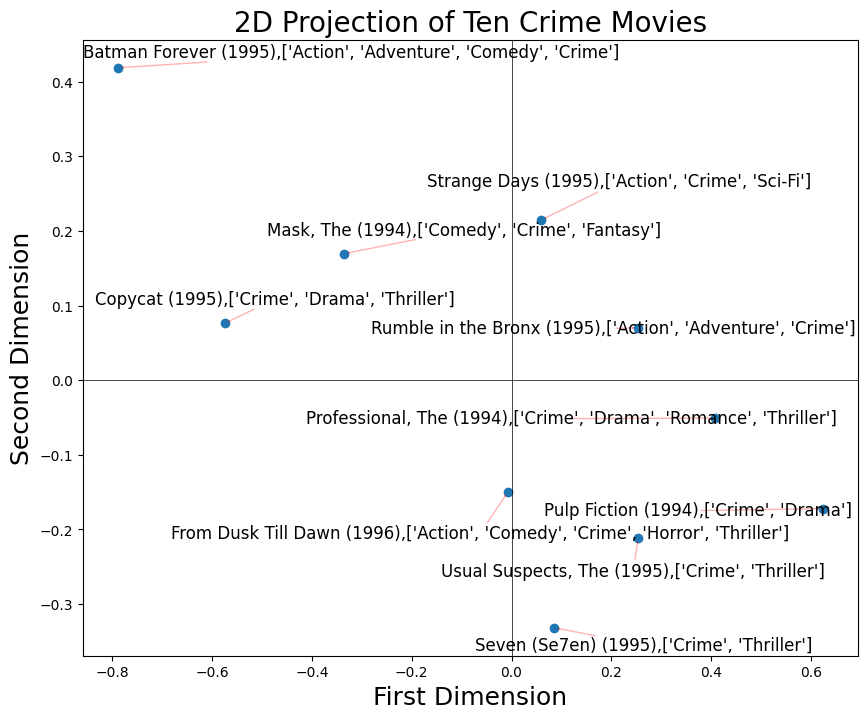

In [ ]:
# Ten movies from the three genres you selected in Section 4

for genre in ['Drama', 'Romance', 'Crime']:

  movies_indices = movies[movies[genre] == 1].head(10).index # no need to 0-index
  movies_2D = V_tilde[:, movies_indices]
  movies_names = all_movie_names[movies_indices]

  plt.figure(figsize=(10, 8))
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  scatter = plt.scatter(movies_2D[0], movies_2D[1])
  labels =[]
  for i, movie in enumerate(movies_names):
      genres = movies.columns[(movies.loc[movies['Movie Title'] == movie] == 1).any()].tolist()
      labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], f'{movie},{genres}', fontsize=12))

  adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

  plt.title(f'2D Projection of Ten {genre} Movies', fontsize=20)
  plt.xlabel('First Dimension', fontsize=18)
  plt.ylabel('Second Dimension', fontsize=18)
  plt.savefig(f'method2-2_{genre}')

## With regularization and decreasing learning rate

Factorizing with  943  users,  1682  movies.
943 1682 20
Epoch 1: err=0.4042475762954743
Epoch 3
----------------------------
Training loss: 0.35766
Test loss: 0.45688

Epoch 4
----------------------------
Training loss: 0.32877
Test loss: 0.44928

Epoch 5
----------------------------
Training loss: 0.31049
Test loss: 0.44536

Epoch 6
----------------------------
Training loss: 0.29813
Test loss: 0.44305

Epoch 7
----------------------------
Training loss: 0.28924
Test loss: 0.44139

Epoch 8
----------------------------
Training loss: 0.28252
Test loss: 0.43997

Epoch 9
----------------------------
Training loss: 0.27725
Test loss: 0.43865

Epoch 10
----------------------------
Training loss: 0.27300
Test loss: 0.43735

Epoch 11
----------------------------
Training loss: 0.26949
Test loss: 0.43608

Epoch 12
----------------------------
Training loss: 0.26653
Test loss: 0.43483

Epoch 13
----------------------------
Training loss: 0.26400
Test loss: 0.43361

Epoch 14
------------------

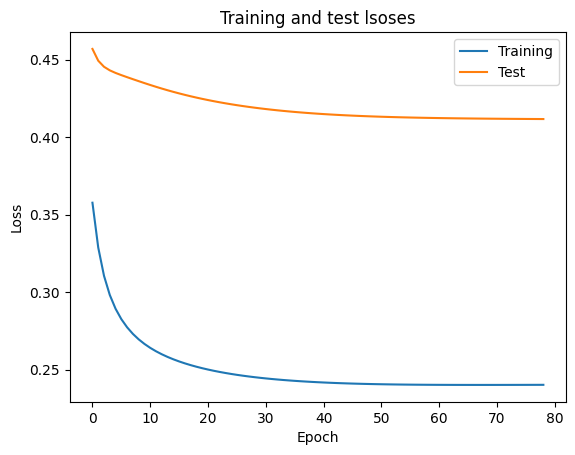

In [ ]:
# Set random seed
np.random.seed(1856)


# SVD model with bias a and b

def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), ai (the ith element of a), bj (the jth
    element of b), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), ai (the ith element of a), bj (the jth element of b),
    mu (the mean of the ratings), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_a(ai, Ui, Yij, Vj, bj, mu, reg, eta):
    """
    Takes as input the scalar ai (the ith element of a), Ui (the ith row of U),
    a training point Yij, the column vector Vj (jth column of V^T), bj (the jth
    element of b), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to ai multiplied by eta.
    """
    return eta * (reg * ai - (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def grad_b(bj, Ui, Yij, Vj, ai, mu, reg, eta):
    """
    Takes as input the scalar bj (the jth element of b), Ui (the ith row of U),
    a training point Yij, the column vector Vj (jth column of V^T), ai (the ith
    element of a), mu (the mean of the ratings), reg (the regularization
    parameter lambda), and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to bj multiplied by eta.
    """
    return eta * (reg * bj - (Yij - mu - np.dot(Ui, Vj) - ai - bj))

def get_err(U, V, a, b, Y, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j, and
    user/movie matrices U and V, and vectors a and b.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for row in Y:
        i, j, Yij = row
        err += (Yij - mu - np.dot(U[i-1], V[j-1]) - a[i-1] - b[j-1])**2
    err /= 2
    return err / len(Y)

def train_model(M, N, K, eta, reg, Y, test_set, eps=0.0001, max_epochs=80):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, a, b, err) consisting of U, V, a, and b, and the
    unregularized MSE of the model.
    """
    U = np.random.random((M, K)) - 0.5
    V = np.random.random((N, K)) - 0.5
    a = np.random.random(M) - 0.5
    b = np.random.random(N) - 0.5
    mu = np.mean([rating for _, _, rating in Y])

    # First epoch
    for i in range(len(Y)):
        j, k, Yij = Y[i]
        U[j-1] -= grad_U(U[j-1], Yij, V[k-1], a[j-1], b[k-1], mu, reg, eta)
        V[k-1] -= grad_V(V[k-1], Yij, U[j-1], a[j-1], b[k-1], mu, reg, eta)
        a[j-1] -= grad_a(a[j-1], U[j-1], Yij, V[k-1], b[k-1], mu, reg, eta)
        b[k-1] -= grad_b(b[k-1], U[j-1], Yij, V[k-1], a[j-1], mu, reg, eta)
    losses = [get_err(U, V, a, b, Y, mu, reg)]
    print('Epoch 1: err={}'.format(losses[0]))

    E_in = []
    E_out = []

    Y_copy = Y.copy()
    # Subsequent epochs
    for epoch in range(2, max_epochs + 1):
        Y_copy = np.random.permutation(Y_copy)

        for i in range(len(Y_copy)):
            j, k, Yij = Y[i]
            U[j-1] -= grad_U(U[j-1], Yij, V[k-1], a[j-1], b[k-1], mu, reg, eta)
            V[k-1] -= grad_V(V[k-1], Yij, U[j-1], a[j-1], b[k-1], mu, reg, eta)
            a[j-1] -= grad_a(a[j-1], U[j-1], Yij, V[k-1], b[k-1], mu, reg, eta)
            b[k-1] -= grad_b(b[k-1], U[j-1], Yij, V[k-1], a[j-1], mu, reg, eta)
        err = get_err(U, V, a, b, Y, mu, reg)
        losses.append(err)

        '''
        print('Epoch {}: err={}'.format(epoch, err))
        if losses[-2] - losses[-1] < eps * (losses[0] - losses[1]):
            break
        '''

        training_loss = get_err(U, V, a, b, Y, mu)
        test_loss = get_err(U, V, a, b, test_set, mu)

        E_in.append(training_loss)
        E_out.append(test_loss)

        print(f"Epoch {epoch+1}\n----------------------------")
        print(f'Training loss: {training_loss:.5f}')
        print(f'Test loss: {test_loss:.5f}\n')

        eta = eta * 0.96


    plt.title('Training and test lsoses')
    plt.plot(E_in, label='Training')
    plt.plot(E_out, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('2d.png')

    return U, V, a, b, losses[-1]


Y_train = np.array(train)
Y_test = np.array(test)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.1
eta = 0.1 # learning rate

print(M, N, K)
U,V, a, b, err = train_model(M, N, K, eta, reg, Y_train, test_set=Y_test)

### Figures

In [ ]:
# Algorithm gives Y = U V^T. For this project, we need Y = U^T V, so U = U.transpose() and V = V.transpose()
SVD = np.linalg.svd(V.T) # get SVD for V
A = SVD[0]
# Project U and V into a two dimensional space
U_tilde =  np.matmul(A[:, :2].T, U.T)
V_tilde =  np.matmul(A[:, :2].T, V.T)

# Used to print movie names on 2d projections
all_movie_names = np.array(movies)[:,1]

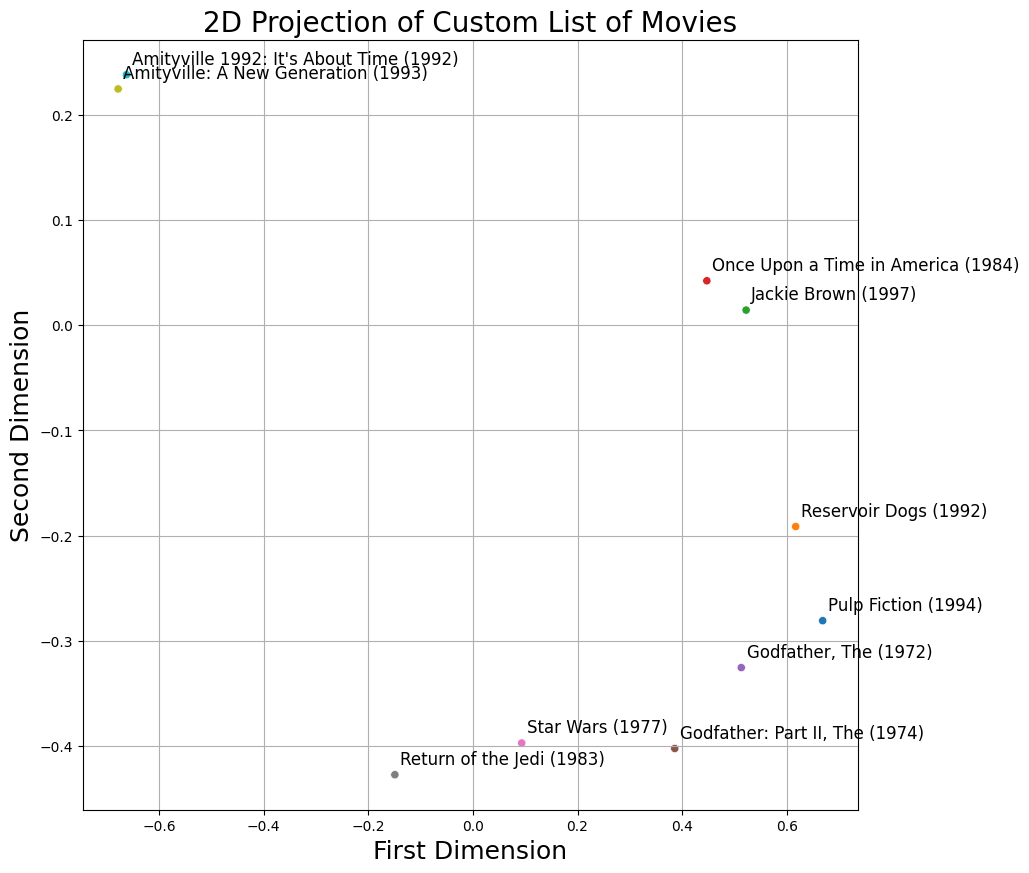

In [ ]:
# Figure for a list of 10 custom movie selections
movies_indices = [56, 156, 346, 649, 127, 187, 50, 181, 439, 437]
movies_indices = [i-1 for i in movies_indices]
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)

plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.grid()
plt.savefig('method2-3_10_custom')
plt.show()
plt.close()

In [ ]:
# Figure for the most popular movies
# All ratings of the ten most popular movies (movies which have received the most ratings).
movies_indices = data["Movie ID"].value_counts().head(10).index - 1 # Make sure to 0-index the movies
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)

plt.title('2D Projection of the Ten Most Popular Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.grid()
plt.savefig('method2-3_10_most_popular')
plt.close()

In [ ]:
# Figure of the ten best movies (movies with the highest average ratings).
average_ratings = data.groupby('Movie ID')['Rating'].mean()
movies_indices = average_ratings.nlargest(10).index -1 # Make sure to 0-index
movies_2D = V_tilde[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
for i, movie in enumerate(movies_names):
    plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)

plt.title('2D Projection of the Ten best Movies (by average ratings)', fontsize=20)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.grid()
plt.savefig('method2-3_10_best_popular(avg)')
plt.close()

In [ ]:
# Ten movies from the three genres you selected in Section 4

for genre in ['Drama', 'Romance', 'Crime']:

  movies_indices = movies[movies[genre] == 1].head(10).index # no need to 0-index
  movies_2D = V_tilde[:, movies_indices]
  movies_names = all_movie_names[movies_indices]

  plt.figure(figsize=(10, 10))
  sns.scatterplot(x=movies_2D[0], y=movies_2D[1], hue=movies_names, legend=False)
  for i, movie in enumerate(movies_names):
      plt.text(movies_2D[0][i] + 0.01, movies_2D[1][i] + 0.01, movie, fontsize=12)

  plt.title(f'2D Projection of Ten {genre} Movies', fontsize=20)
  plt.xlabel('First Dimension', fontsize=18)
  plt.ylabel('Second Dimension', fontsize=18)
  plt.grid()
  plt.savefig(f'method2-3_10_{genre}')
  plt.close()

# Part 3

# **Off-The-Shelf Implementation**

In [ ]:
!pip install scikit-surprise
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.accuracy import mse

In [ ]:
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# Remove duplicates
duplicates = movies[movies.duplicated('Movie Title', keep=False)] # 36 duplicates
# Group the duplicates by their titles so group of duplicates have same 'Movie ID'
duplicate_IDs = duplicates.groupby('Movie Title')['Movie ID'].apply(np.array).reset_index(name='Duplicate ID')['Duplicate ID']
# Consolidate duplicate 'Movie Title's under a single 'Movie ID' to ensure consistency in dataset
for IDs in duplicate_IDs:
  for i in range(1, len(IDs)):
    data['Movie ID'].replace({IDs[i]: IDs[0]}, inplace=True)
    train['Movie ID'].replace({IDs[i]: IDs[0]}, inplace=True)
    test['Movie ID'].replace({IDs[i]: IDs[0]}, inplace=True)

In [ ]:
# Initialize reader and datasets
reader = Reader()
trainset = Dataset.load_from_df(train[['User ID', 'Movie ID', 'Rating']], reader).build_full_trainset()
testset = [test.loc[i].to_list() for i in range(len(test))]

MSE: 0.0536
MSE: 1.2385
Finished: epochs=300, factors=50, lr=0.01, reg=0.01, E_in=0.053612429556649945, E_out=1.2384503501026944
MSE: 0.4103
MSE: 0.8172
Finished: epochs=300, factors=50, lr=0.01, reg=0.1, E_in=0.41029956754959324, E_out=0.8172257547429091
MSE: 0.0478
MSE: 1.3023
Finished: epochs=300, factors=50, lr=0.03, reg=0.01, E_in=0.0477936377540577, E_out=1.3022563351210659
MSE: 0.4188
MSE: 0.8263
Finished: epochs=300, factors=50, lr=0.03, reg=0.1, E_in=0.41880549123531363, E_out=0.8263123428911738
MSE: 0.2327
MSE: 1.4913
Finished: epochs=300, factors=50, lr=0.1, reg=0.01, E_in=0.2326974470211863, E_out=1.491336227801259
MSE: 0.5358
MSE: 0.8906
Finished: epochs=300, factors=50, lr=0.1, reg=0.1, E_in=0.5357581472343774, E_out=0.8906213269694409
MSE: 0.0103
MSE: 1.0009
Finished: epochs=300, factors=100, lr=0.01, reg=0.01, E_in=0.010294538195721887, E_out=1.0008690367690998
MSE: 0.3986
MSE: 0.8156
Finished: epochs=300, factors=100, lr=0.01, reg=0.1, E_in=0.3985555859901956, E_out=0.

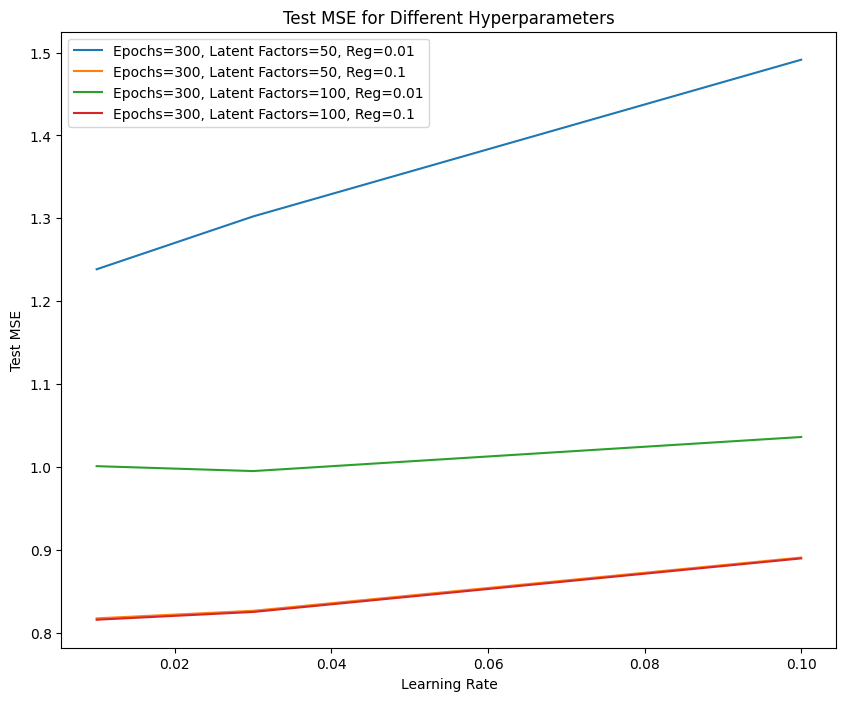

In [ ]:
# Parameters for hyperparameter tuning
n_epochs_list = [300] # used 300 in set 5
n_factors_list = [50, 100]
lr_all_list = [0.01, 0.03, 0.1] # used 0.03 in set 5
reg_all_list = [0.01, 0.1]

results = []

# Train and evaluate models
for n_epochs in n_epochs_list:
    for n_factors in n_factors_list:
        for lr_all in lr_all_list:
            for reg_all in reg_all_list:
                algo = SVD(n_epochs=n_epochs, n_factors=n_factors, lr_all=lr_all, reg_all=reg_all)
                algo.fit(trainset)

                # Evaluate on training data
                train_predictions = algo.test(trainset.build_testset())
                train_error = mse(train_predictions)

                # Evaluate on testing data
                test_predictions = algo.test(testset)
                test_error = mse(test_predictions)

                results.append((n_epochs, n_factors, lr_all, reg_all, train_error, test_error))
                print(f"Finished: epochs={n_epochs}, factors={n_factors}, lr={lr_all}, reg={reg_all}, E_in={train_error}, E_out={test_error}")

# Find best hyperparameters
best_parameters = min(results, key=lambda x: x[5])  # Selecting combination with the lowest test error
print(f"Best hyperparameters: epochs={best_parameters[0]}, latent factors={best_parameters[1]}, lr={best_parameters[2]}, reg={best_parameters[3]}, E_in={best_parameters[4]}, E_out={best_parameters[5]}")

plt.figure(figsize=(10, 8))
for n_epochs in n_epochs_list:
    for n_factors in n_factors_list:
        for reg_all in reg_all_list:
            errors = [result[5] for result in results if result[0] == n_epochs and result[1] == n_factors and result[3] == reg_all]
            plt.plot(lr_all_list, errors, label=f'Epochs={n_epochs}, Latent Factors={n_factors}, Reg={reg_all}')
plt.xlabel('Learning Rate')
plt.ylabel('Test MSE')
plt.legend()
plt.title('Test MSE for Different Hyperparameters')
plt.show()


In [ ]:
# Train the final model on the complete dataset with the best hyperparameters
final_algo = SVD(n_epochs=best_parameters[0], n_factors=best_parameters[1], lr_all=best_parameters[2], reg_all=best_parameters[3])
full_trainset = Dataset.load_from_df(data[['User ID', 'Movie ID', 'Rating']], reader).build_full_trainset()
final_algo.fit(full_trainset)

In [ ]:
V_tilde_shelf = final_algo.qi.T
# Used to print movie names on 2d projections
all_movie_names = np.array(movies)[:,1]

In [ ]:
!pip install adjustText

from adjustText import adjust_text

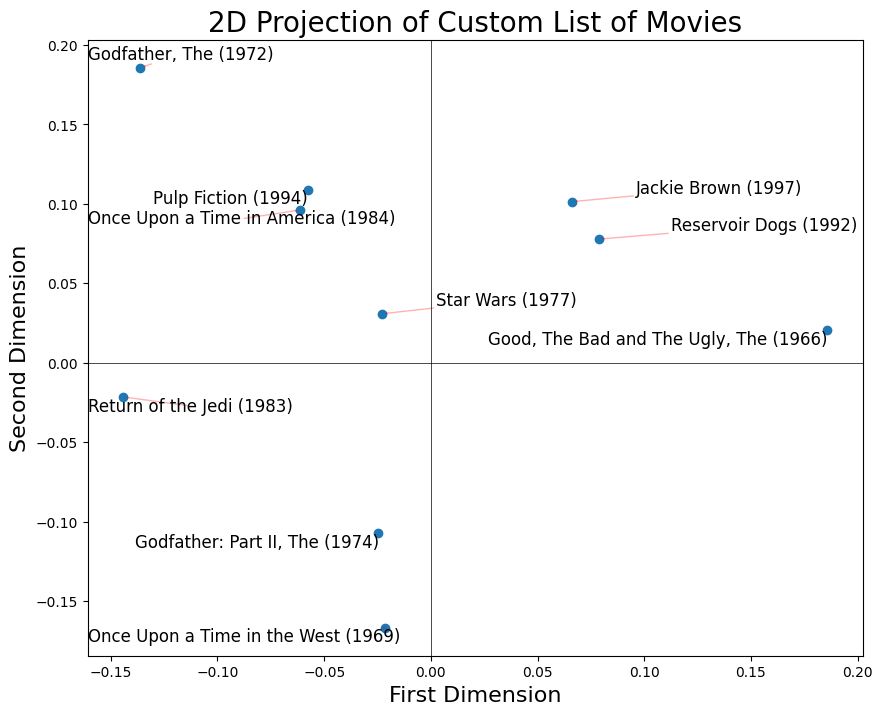

In [ ]:
# Figure for a list of 10 custom movie selections
movies_indices = [56, 156, 177, 346, 646, 649, 127, 187, 50, 181]
movies_indices = [i-1 for i in movies_indices]
movies_2D = V_tilde_shelf[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels = []
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

plt.title('2D Projection of Custom List of Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=16)
plt.ylabel('Second Dimension', fontsize=16)
plt.savefig('method3_10_custom')

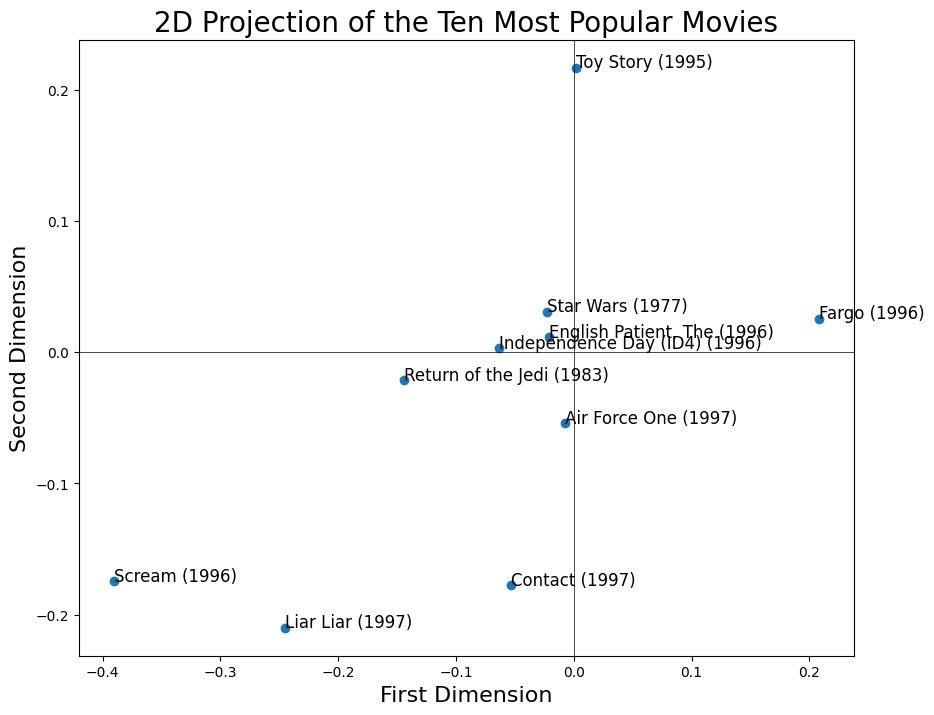

In [ ]:
# Figure for the most popular movies
# All ratings of the ten most popular movies (movies which have received the most ratings).
movies_indices = data["Movie ID"].value_counts().head(10).index - 1 # Make sure to 0-index the movies
movies_2D = V_tilde_shelf[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels = []
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))
plt.title('2D Projection of the Ten Most Popular Movies', fontsize=20)
plt.xlabel('First Dimension', fontsize=16)
plt.ylabel('Second Dimension', fontsize=16)
plt.savefig('method3_10_most_popular')

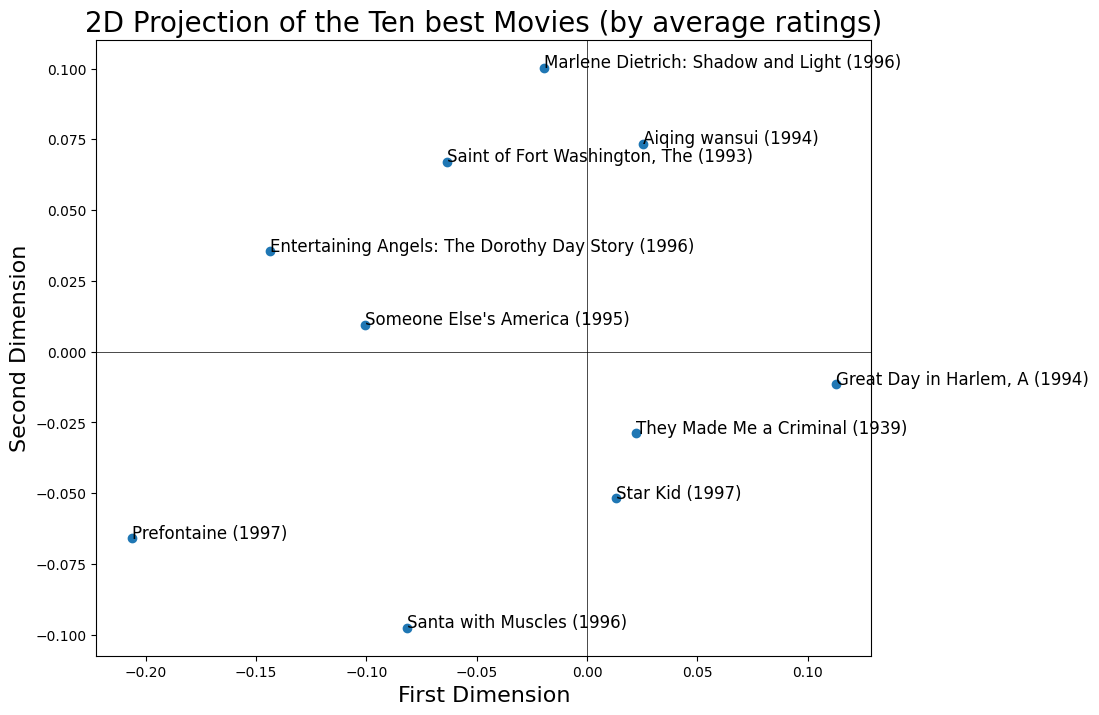

In [ ]:
# Figure of the ten best movies (movies with the highest average ratings).
average_ratings = data.groupby('Movie ID')['Rating'].mean()
movies_indices = average_ratings.nlargest(10).index -1 # Make sure to 0-index
movies_2D = V_tilde_shelf[:, movies_indices]
movies_names = all_movie_names[movies_indices]

plt.figure(figsize=(10, 8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)


scatter = plt.scatter(movies_2D[0], movies_2D[1])
labels = []
for i, movie in enumerate(movies_names):
    labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

# adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

plt.title('2D Projection of the Ten best Movies (by average ratings)', fontsize=20)
plt.xlabel('First Dimension', fontsize=16)
plt.ylabel('Second Dimension', fontsize=16)
plt.savefig('method3_10_best_popular(avg)')

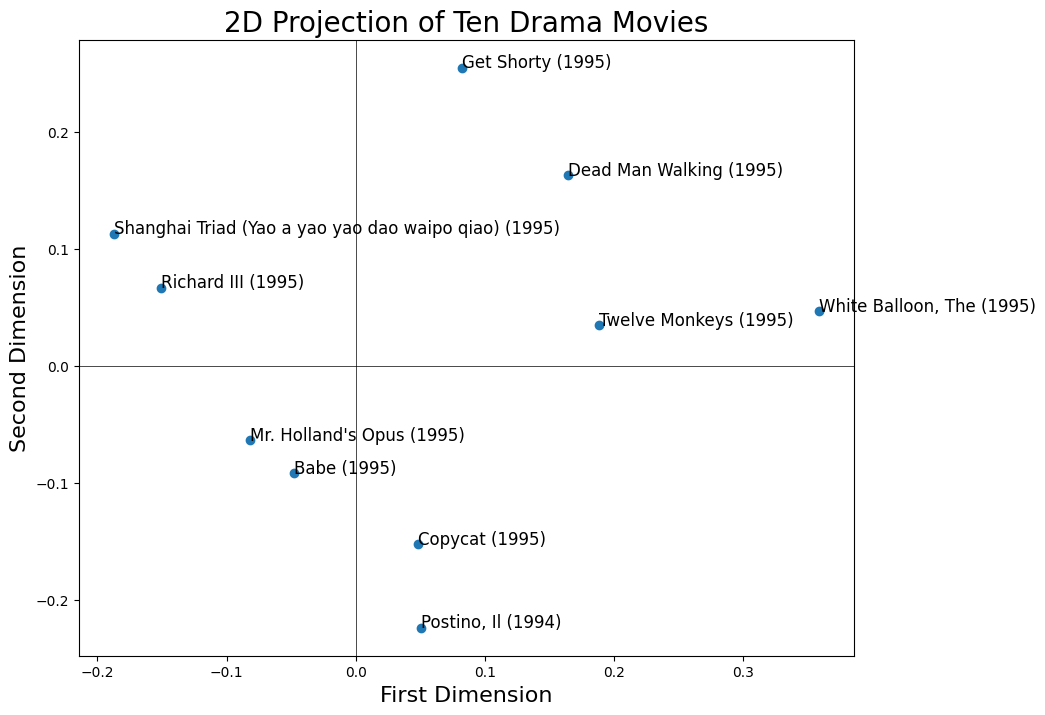

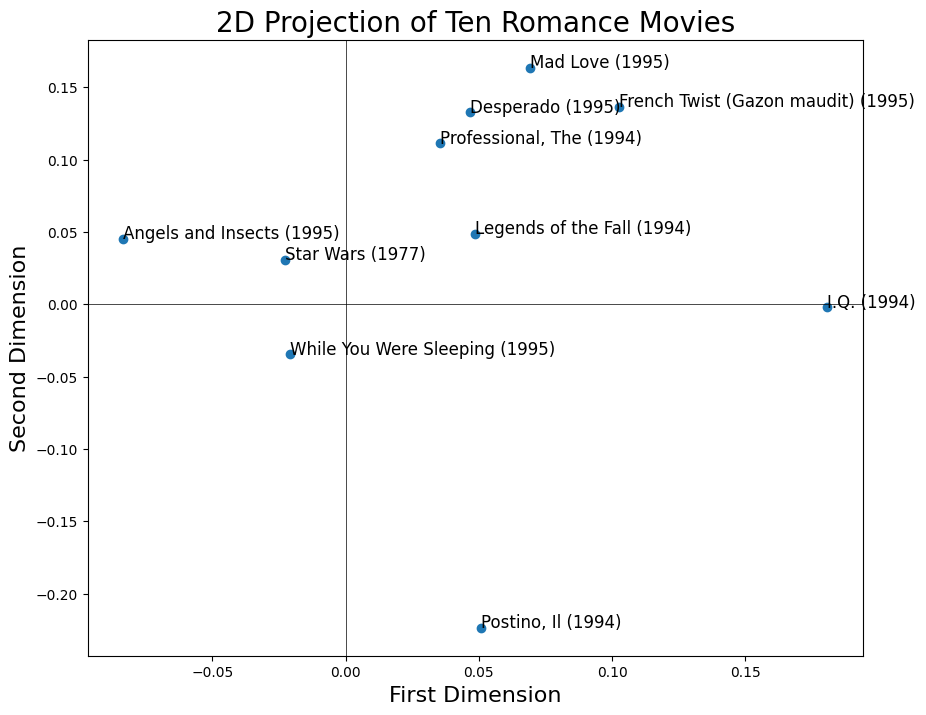

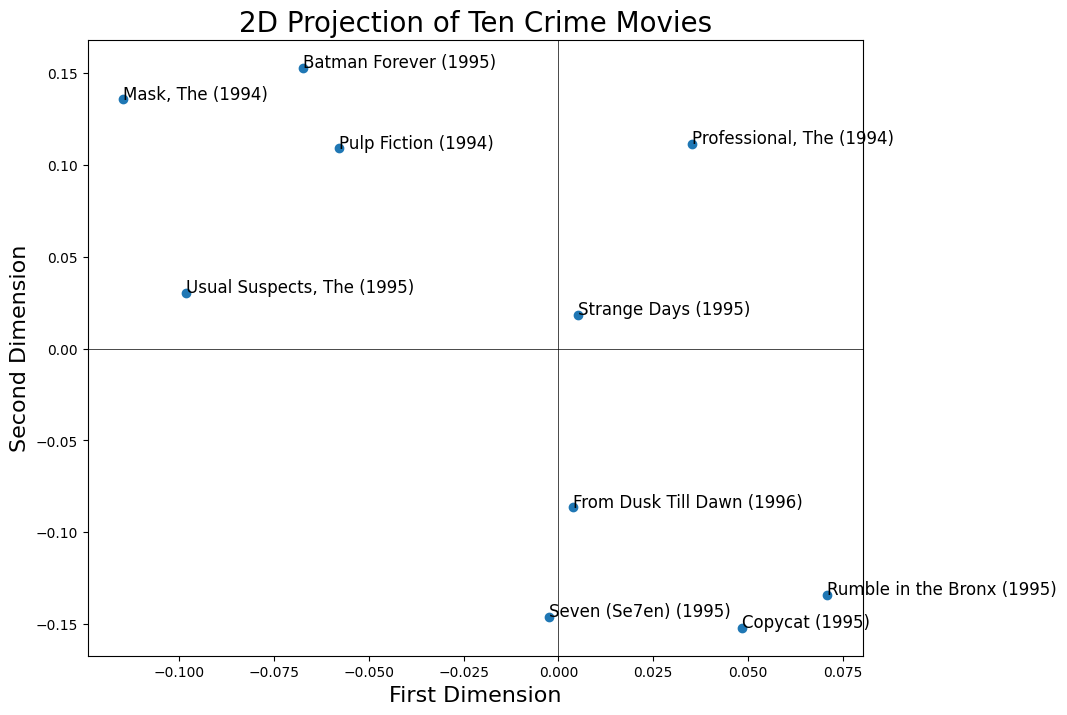

In [ ]:
# Ten movies from the three genres you selected in Section 4

for genre in ['Drama', 'Romance', 'Crime']:

  movies_indices = movies[movies[genre] == 1].head(10).index # no need to 0-index
  movies_2D = V_tilde_shelf[:, movies_indices]
  movies_names = all_movie_names[movies_indices]

  plt.figure(figsize=(10, 8))
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)


  scatter = plt.scatter(movies_2D[0], movies_2D[1])
  labels = []
  for i, movie in enumerate(movies_names):
      labels.append(plt.text(movies_2D[0][i], movies_2D[1][i], movie, fontsize=12))

  # adjust_text(labels, arrowprops=dict(arrowstyle='->', color=(1, 0, 0, 0.3)))

  plt.title(f'2D Projection of Ten {genre} Movies', fontsize=20)
  plt.xlabel('First Dimension', fontsize=16)
  plt.ylabel('Second Dimension', fontsize=16)
  plt.savefig(f'method3_10_{genre}')